In [3]:
import tensorflow as tf
import numpy as np

In [4]:
BATCH_SIZE = 128
IMG_SIZE = (224, 224)

In [5]:
train_dataset = tf.keras.utils.image_dataset_from_directory('data/train', shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
validation_dataset = tf.keras.utils.image_dataset_from_directory('data/val', shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)

Found 1004 files belonging to 2 classes.
Found 376 files belonging to 2 classes.


In [6]:
class_names = train_dataset.class_names

In [7]:
# Split the validation set to create a test set

val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 3
Number of test batches: 0


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [9]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [10]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [11]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [12]:
# converts each image into a 5x5x1280 block of features
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(128, 7, 7, 1280)


In [13]:
base_model.trainable = False

base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [32]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(128, 1280)


In [33]:
middle_layer = tf.keras.layers.Dense(1280, activation='relu')
middle_batch = middle_layer(feature_batch_average)
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(middle_batch)
print(prediction_batch.shape)

(128, 1)


In [34]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [35]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 tf.math.truediv_6 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_6 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                           

## Compiling the Model

In [36]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

In [37]:
initial_epochs = 20

loss0, accuracy0 = model.evaluate(validation_dataset)

3/3 [==============================] - 6s 1s/step - loss: 0.7505 - accuracy: 0.5426


In [38]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.75
initial accuracy: 0.54


In [39]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/20


8/8 [==============================] - 25s 2s/step - loss: 0.7898 - accuracy: 0.5488 - val_loss: 0.7428 - val_accuracy: 0.5559
Epoch 2/20
8/8 [==============================] - 18s 2s/step - loss: 0.7985 - accuracy: 0.5319 - val_loss: 0.7360 - val_accuracy: 0.5559
Epoch 3/20
8/8 [==============================] - 18s 2s/step - loss: 0.7886 - accuracy: 0.5139 - val_loss: 0.7288 - val_accuracy: 0.5585
Epoch 4/20
8/8 [==============================] - 17s 2s/step - loss: 0.7809 - accuracy: 0.5259 - val_loss: 0.7220 - val_accuracy: 0.5691
Epoch 5/20
8/8 [==============================] - 18s 2s/step - loss: 0.7402 - accuracy: 0.5677 - val_loss: 0.7156 - val_accuracy: 0.5665
Epoch 6/20
8/8 [==============================] - 19s 2s/step - loss: 0.7612 - accuracy: 0.5618 - val_loss: 0.7087 - val_accuracy: 0.5771
Epoch 7/20
8/8 [==============================] - 20s 2s/step - loss: 0.7542 - accuracy: 0.5598 - val_loss: 0.7025 - val_accuracy: 0.5824
Epoch 8/20
8/8 [=============================

## Learning Curves

In [40]:
import matplotlib.pyplot as plt

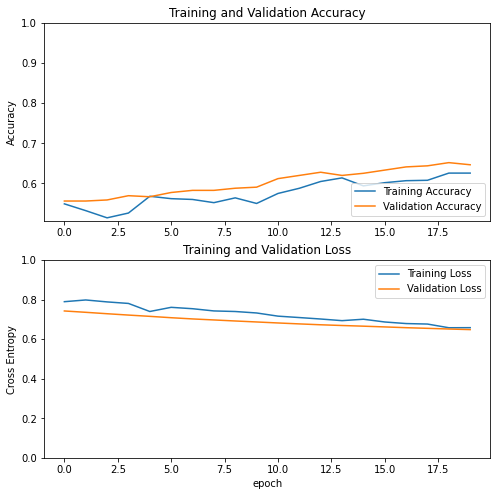

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine Tuning

In [42]:
base_model.trainable = True

In [43]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [44]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

In [45]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 tf.math.truediv_6 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_6 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                           

In [46]:
# Continue training the model

fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 20/40


8/8 [==============================] - 39s 3s/step - loss: 0.6382 - accuracy: 0.6614 - val_loss: 0.6037 - val_accuracy: 0.6755
Epoch 21/40
8/8 [==============================] - 20s 2s/step - loss: 0.5590 - accuracy: 0.7211 - val_loss: 0.5857 - val_accuracy: 0.7154
Epoch 22/40
8/8 [==============================] - 24s 2s/step - loss: 0.5600 - accuracy: 0.7191 - val_loss: 0.5672 - val_accuracy: 0.7207
Epoch 23/40
8/8 [==============================] - 19s 2s/step - loss: 0.5219 - accuracy: 0.7530 - val_loss: 0.5619 - val_accuracy: 0.7234
Epoch 24/40
8/8 [==============================] - 19s 2s/step - loss: 0.5034 - accuracy: 0.7440 - val_loss: 0.5466 - val_accuracy: 0.7340
Epoch 25/40
8/8 [==============================] - 19s 2s/step - loss: 0.4866 - accuracy: 0.7878 - val_loss: 0.5418 - val_accuracy: 0.7367
Epoch 26/40
8/8 [==============================] - 20s 2s/step - loss: 0.4689 - accuracy: 0.7769 - val_loss: 0.5408 - val_accuracy: 0.7420
Epoch 27/40
8/8 [======================

In [47]:
# Looking at the learning curves of the model
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

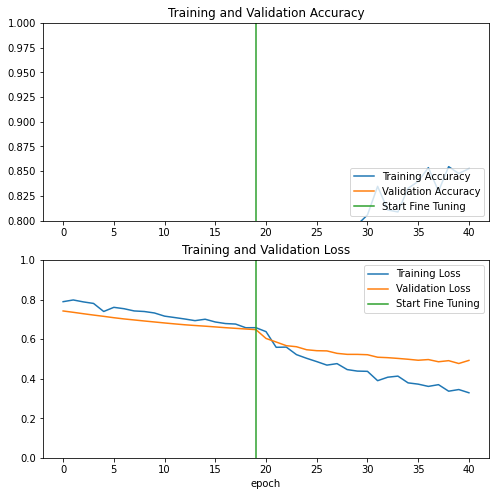

In [48]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [51]:
# Saving the model
model_json = model.to_json()
with open("model3.json", "w") as json_file:
    json_file.write(model_json)
model.save("model3.h5")